In [1]:
!pip install 'kaggle-environments>=0.1.6'

In [2]:
import numpy as np
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from kaggle_environments import evaluate, make, utils

# Define Gym Class

In [3]:
import random

def combined_agent(default_agent, alternate_agent, epsilon):
    def updated_agent(obs, config):
        if (random.random() < epsilon):
            return alternate_agent(obs, config)
        return default_agent(obs,config)
    return updated_agent

from kaggle_environments.envs.connectx.connectx import negamax_agent
from kaggle_environments.envs.connectx.connectx import random_agent

e_greedy_negamax = combined_agent(negamax_agent, random_agent, 0.3)

In [4]:
class ConnectX(gym.Env):
    def __init__(self, switch_prob=0.5):
        self.env = make('connectx', debug=False)
        self.pair = [None, e_greedy_negamax]
        self.trainer = self.env.train(self.pair)
        self.switch_prob = switch_prob

        config = self.env.configuration
        self.action_space = gym.spaces.Discrete(config.columns)
        self.observation_space = gym.spaces.Discrete(config.columns
                * config.rows)

    def switch_trainer(self):
        self.pair = self.pair[::-1]
        self.trainer = self.env.train(self.pair)

    def step(self, action):
        return self.trainer.step(action)

    def reset(self):
        if np.random.random() < self.switch_prob:
            self.switch_trainer()
        return self.trainer.reset()

    def render(self, **kwargs):
        return self.env.render(**kwargs)

# Define Model

In [5]:
class DeepModel(nn.Module):
    def __init__(
        self,
        num_states,
        num_actions,
        ):
        super(DeepModel, self).__init__()
        self.conv1 = nn.Conv2d(1,20,(1,1))
        self.conv2 = nn.Conv2d(1,20,(1,7))
        self.conv3 = nn.Conv2d(1,20,(6,1))
        self.relu = nn.ReLU(inplace=True)
        self.fc = nn.Linear(20*55,128)
        self.output_layer = nn.Linear(128, num_actions)

    def forward(self, x):
        x = x.view(-1,1,6,7)
        self.input_x = x
        x1 = self.relu(self.conv1(x))
        x2 = self.relu(self.conv2(x))
        x3 = self.relu(self.conv3(x))
        x1 = x1.view(-1,20,42)
        x2 = x2.view(-1,20,6)
        x3 = x3.view(-1,20,7)
        x_cat = torch.cat((x1,x2,x3),2)
        x = x_cat.view(-1,20*55)
        x = self.relu(self.fc(x))
        x = self.output_layer(x)
        return x


class DQN:
    def __init__(
        self,
        num_states,
        num_actions,
        gamma,
        max_experiences,
        min_experiences,
        batch_size,
        lr,
        ):
        self.device = torch.device(('cuda'
                                    if torch.cuda.is_available() else 'cpu'
                                   ))
        self.num_actions = num_actions
        self.batch_size = batch_size
        self.gamma = gamma
        self.model = DeepModel(num_states,
                               num_actions).to(self.device)
        print(self.model)
#         self.model.conv1.register_backward_hook(self.backward_hook)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.criterion = nn.MSELoss().to(self.device)
        self.experience = {
            's': [],
            'a': [],
            'r': [],
            's2': [],
            'done': [],
            }
        self.max_experiences = max_experiences
        self.min_experiences = min_experiences

    def predict(self, inputs):
        return self.model(torch.from_numpy(inputs).float().to(self.device))

    def train(self, TargetNet):
        if len(self.experience['s']) < self.min_experiences:
            # only start training process if enough experiences in buffer
            return 0

        # randomly select n experiences in buffer to form batch
        ids = np.random.randint(low=0, high=len(self.experience['s']),
                                size=self.batch_size)
        states = np.asarray([self.preprocess(self.experience['s'][i])
                            for i in ids])
        actions = np.asarray([self.experience['a'][i] for i in ids])
        rewards = np.asarray([self.experience['r'][i] for i in ids])

        # prepare labels
        states_next = np.asarray([self.preprocess(self.experience['s2'
                                 ][i]) for i in ids])
        dones = np.asarray([self.experience['done'][i] for i in ids])
        value_next = \
            np.max(TargetNet.predict(states_next).detach().cpu().numpy(),
                   axis=1)
        actual_values = np.where(dones, rewards, rewards + self.gamma
                                 * value_next)

        actions = np.expand_dims(actions, axis=1)
        actions_one_hot = torch.FloatTensor(self.batch_size,
                self.num_actions).zero_()
        actions_one_hot = actions_one_hot.scatter_(1,
                torch.LongTensor(actions), 1).to(self.device)
        selected_action_values = torch.sum(self.predict(states)
                * actions_one_hot, dim=1).to(self.device)
        actual_values = torch.FloatTensor(actual_values).to(self.device)

        self.optimizer.zero_grad()
        loss = self.criterion(selected_action_values, actual_values)
        loss.backward()
        self.optimizer.step()

    def get_action(self, state, epsilon):
        # to get an action by using epsilon-greedy
        if np.random.random() < epsilon:
            return int(np.random.choice([c for c in range(self.num_actions) if state['board'][c] == 0]))
        else:
            prediction = \
                self.predict(np.atleast_2d(self.preprocess(state)))[0].detach().cpu().numpy()
            for i in range(self.num_actions):
                if state['board'][i] != 0:
                    prediction[i] = -1e7
            return int(np.argmax(prediction))

    def add_experience(self, exp):
        if len(self.experience['s']) >= self.max_experiences:
            for key in self.experience.keys():
                self.experience[key].pop(0)
        for (key, value) in exp.items():
            self.experience[key].append(value)

    def copy_weights(self, TrainNet):
        self.model.load_state_dict(TrainNet.model.state_dict())

    def save_weights(self, path):
        torch.save(self.model.state_dict(), path)

    def load_weights(self, path):
        self.model.load_state_dict(torch.load(path))

    def preprocess(self, state):
        # each state consists of overview of the board and the mark in the obsevations
        # results = (state['board'])[:]
        # results.append(state.mark)
        # return results
        board = (state['board'])[:]
        if state.mark == 1:
            board[board == 2] = -1
        else:
            board[board == 1] = -1
            board[board == 2] = 1
        return board

    def backward_hook(self, module, grad_in, grad_out):
        print(grad_out[0].shape)

In [6]:
def play_game(
    env,
    TrainNet,
    TargetNet,
    epsilon,
    copy_step,
    ):
    rewards = 0
    iter = 0
    done = False
    observations = env.reset()
    while not done:
        action = TrainNet.get_action(observations, epsilon)
        prev_observations = observations
        (observations, reward, done, _) = env.step(action)

        if done:
            if reward == 1:
                reward = 20
            elif reward == 0:
                reward = -20
            else:
                reward = 10
        else:
            reward = 0.5

        rewards += reward

        exp = {
            's': prev_observations,
            'a': action,
            'r': reward,
            's2': observations,
            'done': done,
            }
        
        TrainNet.add_experience(exp)
        TrainNet.train(TargetNet)
        
        iter += 1
        if iter % copy_step == 0:
            TargetNet.copy_weights(TrainNet)
    return rewards

# Training

In [7]:
gamma = 0.99
copy_step = 25
max_experiences = 10000
min_experiences = 100
batch_size = 32
lr = 1e-2
epsilon = 0.9
decay = 0.9999
min_epsilon = 0.1
episodes = 10000

precision = 7

In [8]:
env = ConnectX()

num_states = env.observation_space.n
num_actions = env.action_space.n

all_total_rewards = np.empty(episodes)
all_avg_rewards = np.empty(episodes) # Last 100 steps
all_epsilons = np.empty(episodes)

# Initialize models
TrainNet = DQN(num_states, num_actions, gamma, max_experiences, min_experiences, batch_size, lr)
TargetNet = DQN(num_states, num_actions, gamma, max_experiences, min_experiences, batch_size, lr)
TrainNet.load_weights('weights-deepqconv.pth')
TargetNet.load_weights('weights-deepqconv.pth')

DeepModel(
  (conv1): Conv2d(1, 20, kernel_size=(1, 1), stride=(1, 1))
  (conv2): Conv2d(1, 20, kernel_size=(1, 7), stride=(1, 1))
  (conv3): Conv2d(1, 20, kernel_size=(6, 1), stride=(1, 1))
  (relu): ReLU(inplace=True)
  (fc): Linear(in_features=1100, out_features=128, bias=True)
  (output_layer): Linear(in_features=128, out_features=7, bias=True)
)
DeepModel(
  (conv1): Conv2d(1, 20, kernel_size=(1, 1), stride=(1, 1))
  (conv2): Conv2d(1, 20, kernel_size=(1, 7), stride=(1, 1))
  (conv3): Conv2d(1, 20, kernel_size=(6, 1), stride=(1, 1))
  (relu): ReLU(inplace=True)
  (fc): Linear(in_features=1100, out_features=128, bias=True)
  (output_layer): Linear(in_features=128, out_features=7, bias=True)
)


In [9]:
from tqdm.notebook import tqdm

for n in tqdm(range(episodes)):
    epsilon = max(min_epsilon, epsilon * decay)
    total_reward = play_game(env, TrainNet, TargetNet, epsilon, copy_step)
    all_total_rewards[n] = total_reward
    avg_reward = all_total_rewards[max(0, n - 100):(n + 1)].mean()
    all_avg_rewards[n] = avg_reward
    all_epsilons[n] = epsilon
    

    if n % 1000 == 0:
        print('[{}/{}] episode_reward: {:.3f}, avg_reward: {:.3f}, epsilon: {:.5f}'.format(n,episodes,total_reward, avg_reward, epsilon))
        TrainNet.save_weights('./weights-deepqconv.pth')

[0/10000] episode_reward: 9.500, avg_reward: 9.500, epsilon: 0.89991
[1000/10000] episode_reward: 7.500, avg_reward: 10.198, epsilon: 0.81427
[2000/10000] episode_reward: 11.000, avg_reward: 10.391, epsilon: 0.73678
[3000/10000] episode_reward: 25.500, avg_reward: 11.025, epsilon: 0.66666
[4000/10000] episode_reward: 11.500, avg_reward: 10.802, epsilon: 0.60322
[5000/10000] episode_reward: 8.500, avg_reward: 11.144, epsilon: 0.54581
[6000/10000] episode_reward: 8.500, avg_reward: 10.361, epsilon: 0.49387
[7000/10000] episode_reward: 9.000, avg_reward: 9.738, epsilon: 0.44687
[8000/10000] episode_reward: 11.500, avg_reward: 10.233, epsilon: 0.40434
[9000/10000] episode_reward: 7.500, avg_reward: 11.361, epsilon: 0.36586



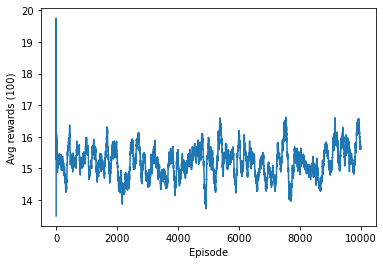

In [10]:
plt.plot(all_avg_rewards)
plt.xlabel('Episode')
plt.ylabel('Avg rewards (100)')
plt.show()

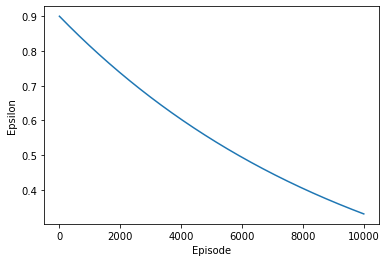

In [11]:
plt.plot(all_epsilons)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.show()

In [60]:
TrainNet.save_weights('./weights-deepqconv.pth')

# Create Agent

In [12]:
def my_agent(observation, configuration):
    return TrainNet.get_action(observation, 0.1)

In [22]:
fc_layers = []

# Get all hidden layers' weights
for i in range(len(hidden_units)):
    fc_layers.extend([
        TrainNet.model.hidden_layers[i].weight.T.tolist(), # weights
        TrainNet.model.hidden_layers[i].bias.tolist() # bias
    ])

# Get output layer's weights
fc_layers.extend([
    TrainNet.model.output_layer.weight.T.tolist(), # weights
    TrainNet.model.output_layer.bias.tolist() # bias
])

# Convert all layers into usable form before integrating to final agent
fc_layers = list(map(
    lambda x: str(list(np.round(x, precision))) \
        .replace('array(', '').replace(')', '') \
        .replace(' ', '') \
        .replace('\n', ''),
    fc_layers
))
fc_layers = np.reshape(fc_layers, (-1, 2))

# Create the agent
my_agent = '''def my_agent(observation, configuration):
    import numpy as np

'''

# Write hidden layers
for i, (w, b) in enumerate(fc_layers[:-1]):
    my_agent += '    hl{}_w = np.array({}, dtype=np.float32)\n'.format(i+1, w)
    my_agent += '    hl{}_b = np.array({}, dtype=np.float32)\n'.format(i+1, b)
# Write output layer
my_agent += '    ol_w = np.array({}, dtype=np.float32)\n'.format(fc_layers[-1][0])
my_agent += '    ol_b = np.array({}, dtype=np.float32)\n'.format(fc_layers[-1][1])

my_agent += '''
    state = observation.board[:]
    state.append(observation.mark)
    out = np.array(state, dtype=np.float32)

'''

# Calculate hidden layers
for i in range(len(fc_layers[:-1])):
    my_agent += '    out = np.matmul(out, hl{0}_w) + hl{0}_b\n'.format(i+1)
    my_agent += '    out = 1/(1 + np.exp(-out))\n' # Sigmoid function
# Calculate output layer
my_agent += '    out = np.matmul(out, ol_w) + ol_b\n'

my_agent += '''
    for i in range(configuration.columns):
        if observation.board[i] != 0:
            out[i] = -1e7

    return int(np.argmax(out))
    '''


NameError: name 'hidden_units' is not defined

In [ ]:
with open('submission_conv.py', 'w') as f:
    f.write(my_agent)

In [ ]:
from submission_conv import my_agent

In [13]:
def mean_reward(rewards):
    return np.round(rewards.count([1,-1])/len(rewards),2)

print("My Agent vs. Random Agent:", mean_reward(evaluate("connectx", [my_agent, "random"], num_episodes=10)))
print("My Agent vs. Negamax Agent:", mean_reward(evaluate("connectx", [my_agent, "negamax"], num_episodes=10)))
print("Random Agent vs. My Agent:", mean_reward(evaluate("connectx", ["random", my_agent], num_episodes=10)))
print("Negamax Agent vs. My Agent:", mean_reward(evaluate("connectx", ["negamax", my_agent], num_episodes=10)))

My Agent vs. Random Agent: 0.8
My Agent vs. Negamax Agent: 0.0
Random Agent vs. My Agent: 0.1
Negamax Agent vs. My Agent: 0.9
